# This code uses the new discrete code

In this python notebook, we will test the ability to learn trajectory of "Slide Around" using ACTOR-CRITIC RL algorithm.

In [1]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, action_learner_search, value_estimator
from rl import block_movement_env
from rl import discrete_value_estimator as  dve
from rl import discrete_action_learner as dal

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
reload(dal)
dal._test_get_action_from_quantized_states()

The action from (2, 1) to (1, 0) is illegal
The action 2 from (2, 1) to (2, 0)
The action from (2, 1) to (3, 0) is illegal
The action 3 from (2, 1) to (1, 1)
The action 0 from (2, 1) to (2, 1)
The action 1 from (2, 1) to (3, 1)
The action from (2, 1) to (1, 2) is illegal
The action 4 from (2, 1) to (2, 2)
The action from (2, 1) to (3, 2) is illegal


In [3]:
dal._test_realize_action()

quantized (1, 1.0)
action [0.4767767 0.5767767 0.       ]
requantized (0, 1.0)
action [0.65355339 0.75355339 0.        ]
requantized (1, 1.0)
action [0.55 0.4  0.  ]
requantized (0, 0.0)
action [0.83033009 0.93033009 0.        ]
requantized (2, 1.0)
action [0.3  0.65 0.  ]
requantized (0, 2.0)


In [209]:
### RELOAD modules here
reload(config)
reload(value_estimator)
reload(config)
reload(block_movement_env)
reload(action_learner_search)
reload(progress_learner)
reload(dal)
reload(dve)


### MAIN CODE
tf.reset_default_graph()

c = config.Qual_Plan_Config()

global_step = tf.Variable(0, name="global_step", trainable=False)


policy_est = dve.DiscretePolicyEstimator(c)
value_est = dve.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load(os.path.join('..' , 'learned_models', p_name))

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training = False,
                                                                                    is_dropout = False, 
                                                                                    name = projects[project_name].name, 
                                                                                    config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, os.path.join('..' , 'learned_models', 'progress_' + project_name + '.mod.1'))

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
INFO:tensorflow:Restoring parameters from ..\learned_models\progress_SlideAround.mod.1


Following we use the following learning rate and decy

policy_learning_rate = 0.2

policy_decay = 0.999
    
value_learning_rate = 0.1
    
value_decay = 0.98

In [180]:
#reload(dal)
c.num_episodes = 2000

# Effective number of steps would be limit_step // (breadth + 1)
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs, stats = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

Step 2 @ Episode 2000/2000 (0.06220727413892746)))

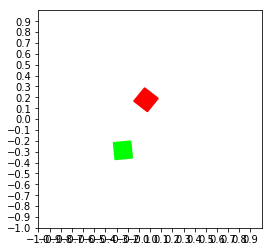

(None, None)
[ 0.25466323 -0.23941366  0.095742  ]
[[ 0.   0.  -1.   0.  -1.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.59; reward = 0.59


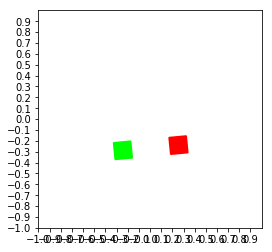

(None, None)
[ 0.14268552 -0.60534754  0.095742  ]
[[ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.61; reward = 0.02


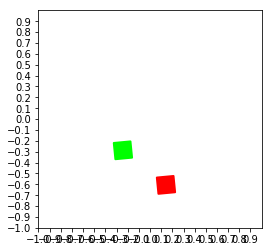

(None, None)
[-0.05018068 -0.44627955  0.095742  ]
[[ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]]
Progress = 0.05; reward = -0.56


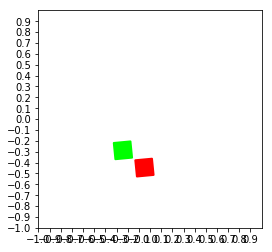

(None, None)
[-0.21914794 -0.53606662  0.095742  ]
[[ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.31; reward = 0.26


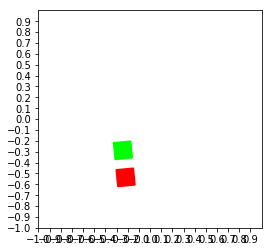

In [188]:
past_envs[1995].env.replay(verbose = True)

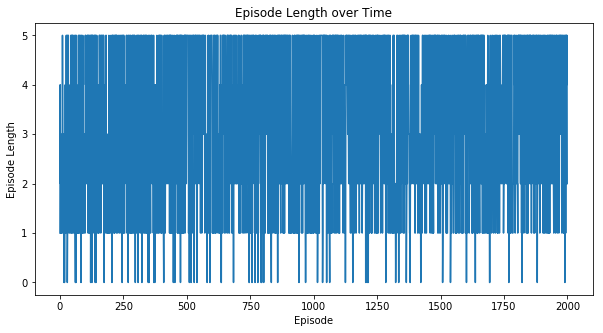

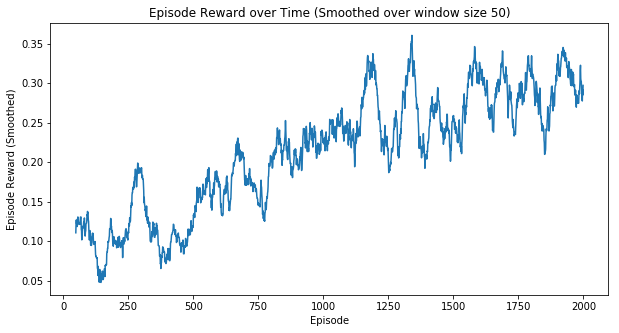

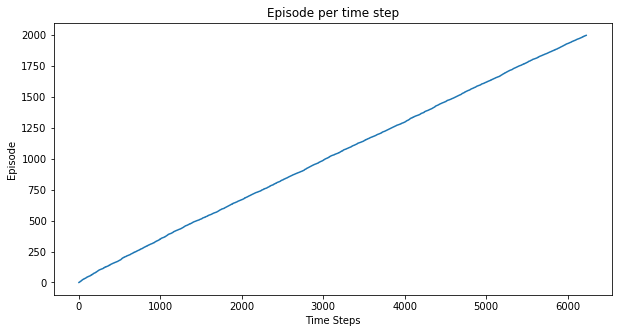

(<matplotlib.figure.Figure at 0x21e435d2780>,
 <matplotlib.figure.Figure at 0x21e598808d0>)

In [183]:
plotting.plot_episode_stats(stats, smoothing_window=50)

In [5]:
reload(block_movement_env)
#reload(progress_learner)
bme = block_movement_env.BlockMovementEnv(c, projects['SlideAround'].speed, projects['SlideAround'].name, 
                progress_estimator = progress_estimators['SlideAround'], session = sess)

In [192]:
import numpy as np

def print_action_prob(policy_est):
    for progress in range(5):
        for pos in range(6):
            for prev_action in range(5):
                if (pos == 0 or pos == 3) and prev_action == 1:
                    # Illegal
                    continue

                if (pos == 2 or pos == 5) and prev_action == 3:
                    # Illegal
                    continue

                print ('pos = %d, prev_action = %d, progress = %d' % (pos, prev_action, progress) )

                state = np.zeros(150)
                index = int(pos * 25 + prev_action * 5 + progress)

                state[index] = 1

                probs = policy_est.predict(state, sess = sess)

                best_action = np.argmax(probs)
                print ('probs = %s, best_action = %d' % (probs, best_action) )
                
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.11560918 0.05975545 0.70296913 0.0405202  0.08114599], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.21192178 0.18276869 0.22514473 0.18118778 0.198977  ], best_action = 2
pos = 0, prev_action = 3, progress = 0
probs = [0.16873729 0.1704726  0.21312693 0.2278958  0.21976736], best_action = 3
pos = 0, prev_action = 4, progress = 0
probs = [0.21313553 0.21457502 0.2179609  0.16984092 0.18448764], best_action = 2
pos = 1, prev_action = 0, progress = 0
probs = [0.02882295 0.00775403 0.94172907 0.00794909 0.01374476], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.19226359 0.17790374 0.2197517  0.17445207 0.23562892], best_action = 4
pos = 1, prev_action = 2, progress = 0
probs = [0.19164194 0.2080846  0.22903635 0.17773563 0.19350143], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.20863695 0.17365862 0.22597036 0.19261537 0.19911872], best_action = 2
pos = 1, prev_action = 4, progre

In [197]:
import time

start_time = time.time()

c.num_episodes = 10000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_2 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_2, stats_2 = action_ln_2.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 1 @ Episode 10000/10000 (0.21492771804332733)Run finish after 34032


Step 1 @ Episode 10000/10000 (0.21492771804332733)Run finish after 34032

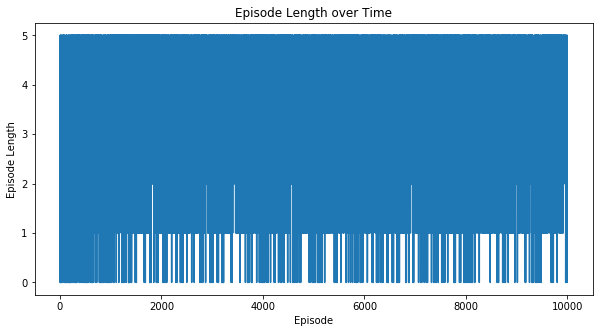

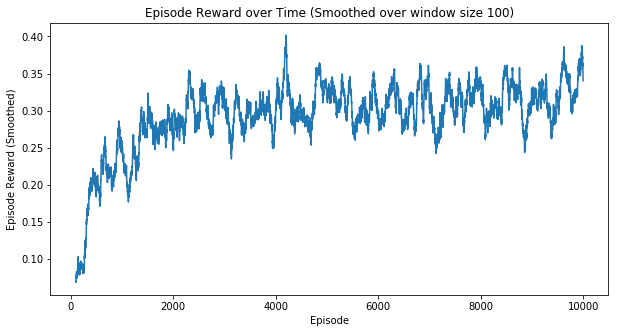

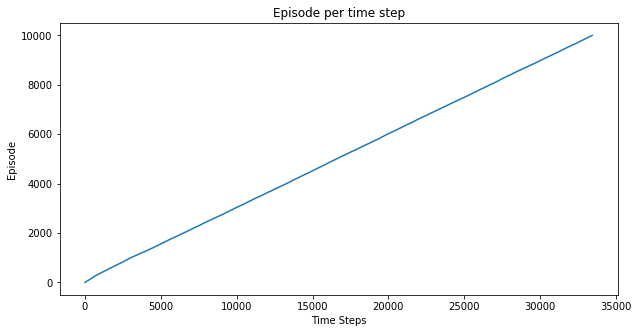

(<matplotlib.figure.Figure at 0x21ebc240860>,
 <matplotlib.figure.Figure at 0x21ed1730e48>)

In [199]:
plotting.plot_episode_stats(stats_2, smoothing_window=100)

In [200]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.04033542 0.01609073 0.8853315  0.02386988 0.03437242], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.18508157 0.19495568 0.17084895 0.24698135 0.20213245], best_action = 3
pos = 0, prev_action = 3, progress = 0
probs = [0.1885644  0.18258478 0.2078884  0.18889949 0.23206295], best_action = 4
pos = 0, prev_action = 4, progress = 0
probs = [0.18026705 0.21004896 0.18109591 0.20234026 0.2262478 ], best_action = 4
pos = 1, prev_action = 0, progress = 0
probs = [0.01446648 0.00506477 0.96763235 0.00772114 0.00511526], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.2316514  0.19011293 0.16963097 0.24191612 0.1666886 ], best_action = 3
pos = 1, prev_action = 2, progress = 0
probs = [0.21398306 0.23207778 0.18596579 0.1972843  0.17068909], best_action = 1
pos = 1, prev_action = 3, progress = 0
probs = [0.198546   0.19231519 0.25475985 0.17536072 0.17901821], best_action = 2
pos = 1, prev_action = 4, progre

In [201]:
c.num_episodes = 1000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_3 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_3, stats_3 = action_ln_2.policy_learn(dal.random_action, breadth = 3, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 1 @ Episode 1000/1000 (0.7421432137489319)Run finish after 71401


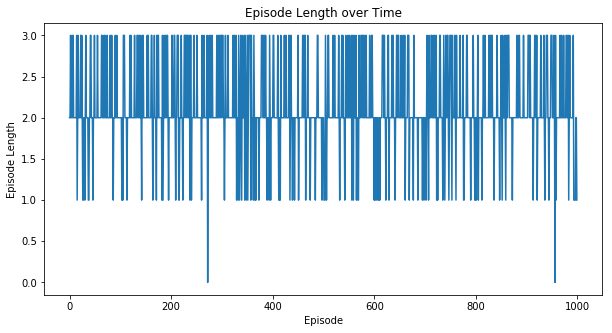

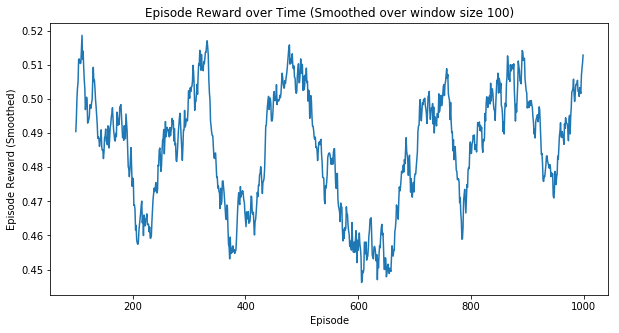

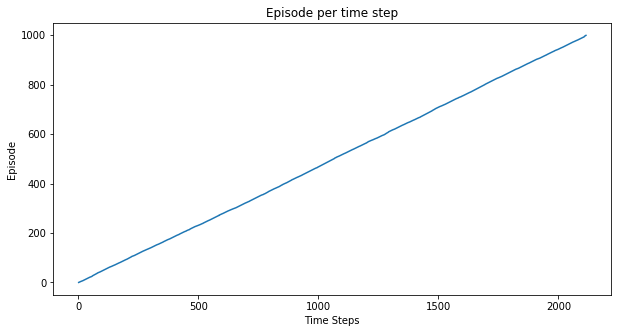

(<matplotlib.figure.Figure at 0x21ee6fcb860>,
 <matplotlib.figure.Figure at 0x21ee71314a8>)

In [203]:
plotting.plot_episode_stats(stats_3, smoothing_window=100)

In [205]:
c.num_episodes = 2000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_4 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_4, stats_4 = action_ln_4.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'REINFORCE', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 0 @ Episode 2000/2000 (0.674066960811615)Run finish after 75554


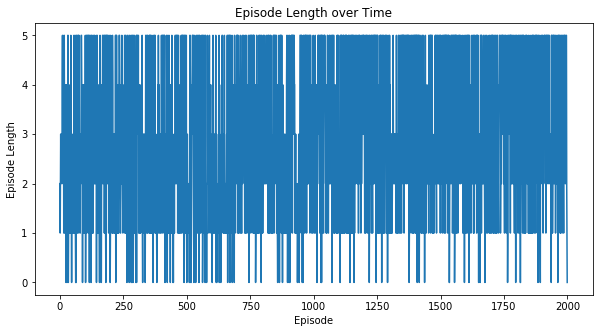

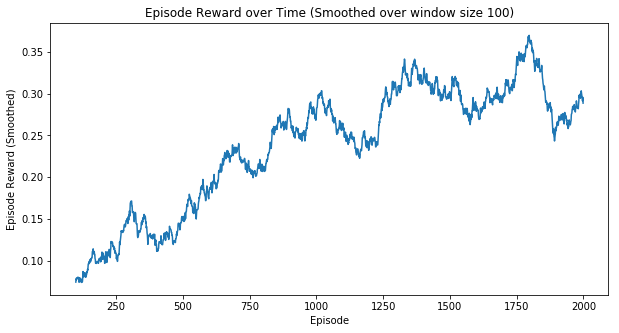

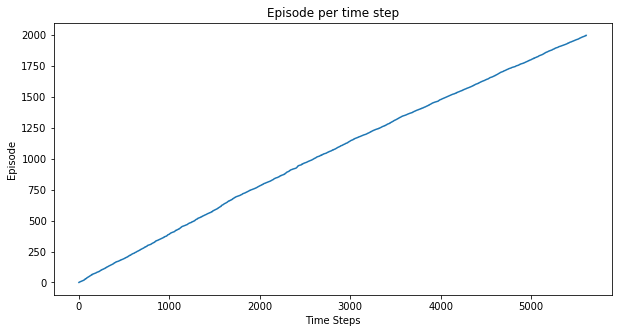

(<matplotlib.figure.Figure at 0x21ee868d0b8>,
 <matplotlib.figure.Figure at 0x21ee864fe48>)

In [206]:
plotting.plot_episode_stats(stats_4, smoothing_window=100)

In [208]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.43276381 0.12610538 0.22748412 0.07284497 0.14080176], best_action = 0
pos = 0, prev_action = 2, progress = 0
probs = [0.2317134  0.19269374 0.22860385 0.17521039 0.1717787 ], best_action = 0
pos = 0, prev_action = 3, progress = 0
probs = [0.21422206 0.17884219 0.18776898 0.23214772 0.18701904], best_action = 3
pos = 0, prev_action = 4, progress = 0
probs = [0.23193984 0.23091899 0.17400612 0.18296893 0.18016616], best_action = 0
pos = 1, prev_action = 0, progress = 0
probs = [0.01180444 0.0033196  0.9761411  0.00361269 0.00512216], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.21289343 0.20069966 0.21334763 0.1771605  0.19589876], best_action = 2
pos = 1, prev_action = 2, progress = 0
probs = [0.18736954 0.17491302 0.23307775 0.21347693 0.1911628 ], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.20318663 0.23521215 0.15189482 0.24037269 0.1693337 ], best_action = 3
pos = 1, prev_action = 4, progre

In [ ]:
start_time = time.time()

c.num_episodes = 10000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_5 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_5, stats_5 = action_ln_5.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'REINFORCE', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 0 @ Episode 2959/10000 (0.14073314983397722))))